In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split

df = pd.read_csv('data.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

def cv_evaluate(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'r2': make_scorer(r2_score),
        'mae': make_scorer(mean_absolute_error),
        'mse': make_scorer(mean_squared_error)
    }
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

    for key in cv_results.keys():
        if key in ['fit_time', 'score_time']:
            continue
        print(f"{key}: {cv_results[key]}")
        print(f"{key} trung bình: {cv_results[key].mean():.3f} ± {cv_results[key].std():.3f}")
        print()

In [4]:
pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', SVR())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()), ('svr', SVR())])

In [5]:
print_metrics(*evaluate_model(pipeline, X_train, y_train))

MSE: 3.428
MAE: 1.030
R2: 0.929


In [6]:
print_metrics(*evaluate_model(pipeline, X_test, y_test))

MSE: 3.612
MAE: 1.153
R2: 0.926


## Use validation set to optimize params

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

In [8]:
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['rbf', 'linear', 'poly'],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('te',
                                        TargetEncoder(cols=['nationality'])),
                                       ('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['rbf', 'linear', 'poly']},
             scoring='neg_mean_squared_error', verbose=1)

In [9]:
print('Best params:', grid_search.best_params_)
print('Best score:', -grid_search.best_score_)

Best params: {'svr__C': 10, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best score: 3.186898147554834


In [10]:
final_model = grid_search.best_estimator_

final_model.fit(X_train, y_train)

print("=== Đánh Giá Mô Hình SVR Sau Khi GridSearch ===")
print("Training Set:")
print_metrics(*evaluate_model(final_model, X_train, y_train))
print("\nTest Set:")
print_metrics(*evaluate_model(final_model, X_test, y_test))

=== Đánh Giá Mô Hình SVR Sau Khi GridSearch ===
Training Set:
MSE: 2.309
MAE: 0.647
R2: 0.952

Test Set:
MSE: 2.954
MAE: 0.983
R2: 0.940


In [18]:
cv_evaluate(final_model, X, y)

test_r2: [0.93916727 0.93667465 0.93901839 0.93015037 0.9315724 ]
test_r2 trung bình: 0.935 ± 0.004

test_mae: [0.98453692 0.9803262  0.97100858 1.02641285 0.99962804]
test_mae trung bình: 0.992 ± 0.019

test_mse: [2.95803036 3.04547963 2.95213533 3.29907266 3.35977681]
test_mse trung bình: 3.123 ± 0.173



In [11]:
svr = final_model.named_steps['svr']
svr

SVR(C=10, gamma='auto')

In [12]:
import joblib

joblib.dump(svr, 'svr_model.pkl')
print("Mô hình SVR đã được lưu thành công dưới tên 'svr_model.pkl'")

Mô hình SVR đã được lưu thành công dưới tên 'svr_model.pkl'


In [13]:
import joblib

svr = joblib.load('svr_model.pkl')

print("Mô hình SVR đã được tải lại thành công.")

Mô hình SVR đã được tải lại thành công.


In [14]:
pipeline = Pipeline([
    ('te', TargetEncoder(cols=['nationality'])),
    ('scaler', StandardScaler()),
    ('svr', svr)
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('te', TargetEncoder(cols=['nationality'])),
                ('scaler', StandardScaler()),
                ('svr', SVR(C=10, gamma='auto'))])

In [15]:
y_pred = pipeline.predict(X_test)

predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [16]:
sorted_predictions_df = predictions_df.reset_index(drop=True)
print(sorted_predictions_df.head(20))

    Actual  Predicted
0       60  60.754988
1       55  60.557545
2       64  63.616338
3       70  69.196472
4       52  52.255248
5       71  72.155738
6       70  70.424940
7       70  69.542084
8       67  71.321992
9       70  69.063117
10      69  70.460858
11      67  64.424845
12      68  69.366278
13      66  66.015758
14      71  70.729440
15      72  72.940998
16      51  55.944605
17      70  70.465492
18      73  72.901951
19      74  73.976469


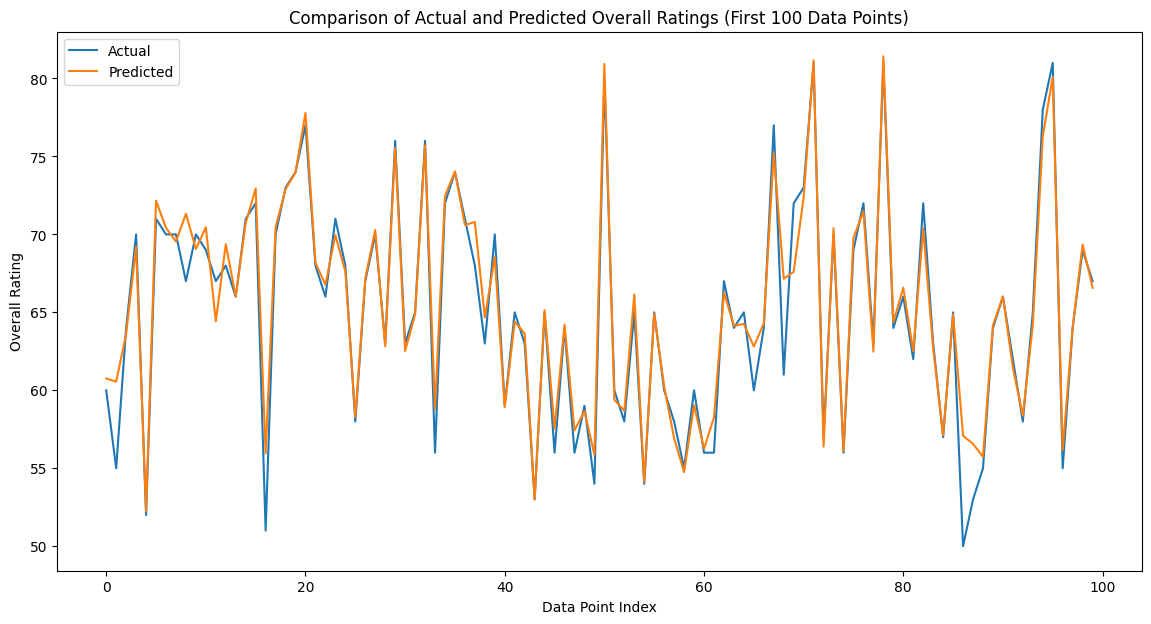

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(sorted_predictions_df['Actual'][:100].values, label='Actual')
plt.plot(sorted_predictions_df['Predicted'][:100].values, label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Overall Rating')
plt.title('Comparison of Actual and Predicted Overall Ratings (First 100 Data Points)')
plt.legend()
plt.show()